# Karras pre-conditioning

The NVIDIA (Karras) paper ["Elucidating the Design Space of Diffusion-Based Generative Models"](http://arxiv.org/abs/2206.00364),
Karras et al. takes an explicit look at the question of scaling. 
<sub><sup>their approach was to think how should things be. Our approach is more fun because we never quite know what's going to happen.</sup></sub>
Given all things coming into a model, how can we have them all nicely balanced.
We refer often to the paper in the discussion.
<br>
We can either predict the noise or predict the clean image, each can be better in different situations.
Given nearly Pure Noise, to predict the noise is a waste of time, because the whole thing is noise.
Similarly, predicting the clean image when given a nearly ckean image is also a waste of time.
<mark>We want an equally difficult problem to solve regardless of how noisy the image is.</mark>

In [23]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [24]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

The start of this is all the same, except now we are going to do it -1 to 1 as we rely on the paper's carefully designed scaling.
*except that I put it back in the notebook as well*

In [25]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [26]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 128 #256 #512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb,yb = b = next(iter(dl))

`sig_data` is the standard deviation of the actual data, calculated for a batch `xb.std()`.

In [28]:
sig_data = xb.std() ; sig_data   #sig_data = 0.66 before a bug was fixed.

### FORMULA

$c_{skip}$ is a number which indicates what is the training target.
It is not predict the noise nor the image all the time, but predict a lerpt version of one or the other, depending on how noisy it is.
In the norm formula below, **y**  is the plain image (clean signal), **n** is the noise, **y + n** is the noised image.
If $c_{skip}= 0$ we predict the target clean image **y**, and if $c_{skip} = 1$ we predict the noise **n**.
The $c_{skip}$ value indicates if we're predicting the clean image or the noise or something in between the two.
$c_{skip}(\sigma)$ is a simpler notation, no more Alphabars, Alphas, betas, betabars.
$\sigma$ is the same thing as Alphabar used to be.
It simplified, but also confused, by using an existing symbol for something totally different!

**y** is clean signal, **n** is N(0,1) noise.

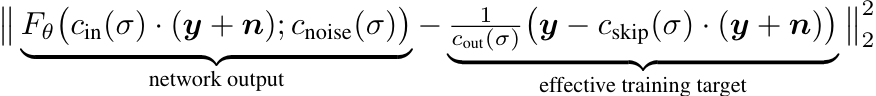

`scalings(sig)` calculates and return $c_{skip}, c_{out}, c_{in}$.
`sig**2` is the definition of the variance of the noise, `sig_data**2` the variance of the data.
We add those two variances together to get the total variance, `totvar` at a level of $\sigma$ `sig`. 

In [29]:
def scalings(sig):
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

Fig 5a in the paper (below) looks at the loss to see how good is a trained model at predicting when $\sigma$ (alphabar) is low, middle or high.
When it is nearly all noise or nearly no noise, we are not able to do anything, i.e., we can do good when there is a medium amount of noise.

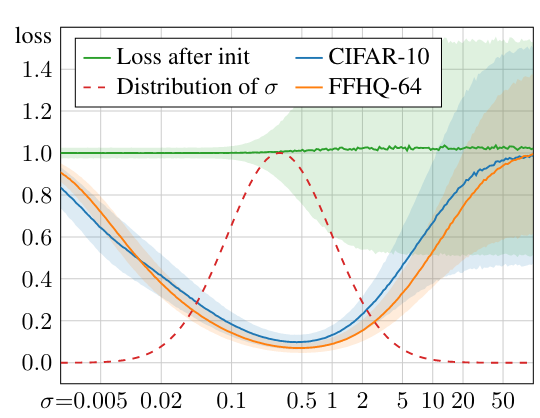

To figure out some $\sigma$s let's get a distribution of $\sigma$s that matches the red curve in the Figure.
Is a normally distributed curve on a log scale, a **log-normal** curve.
To get the $\sigma$s they picked a normally distributed random number, and then `exp()`.
This is a log normal distribution, with a mean of -1.2 and a standard deviation of 1.2.
About 1/3 of the time it gets a $\sigma > 0$, exp(0)=1, and about 1/3 of the time $\sigma > 1$.

In [30]:
sig_samp = (torch.randn([10000])*1.2-1.2).exp()

An histogram of the $\sigma$s that we're going to use, nearly always less than 5, but sometimes it's way out there.

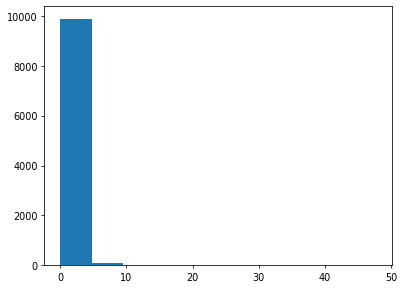

In [31]:
plt.hist(sig_samp);

It is hard to read these histograms so we use `seaborn` (built on top of matplotlib) which has
sophisticated and nicer looking plots.

In [32]:
import seaborn as sns

The KDE (kernel density) is a smooth histogram plot.
Clipped it at 10 to see it better that the majority of the time is 0.4-0.5, but sometimes it's going to be really big.

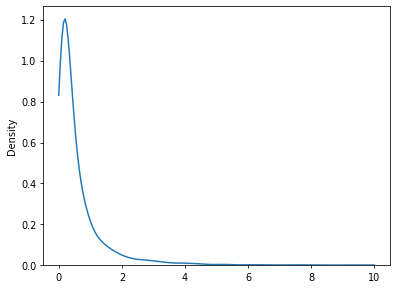

In [33]:
sns.kdeplot(sig_samp, clip=(0,10));

Noiseify picks a $\sigma$ `sig` using a log normal distribution, and then we get the `noise` as usual.
Then to find something between the plain image `x0` and the `noised_input`, we call `scalings(sig)` to get $c_{skip}, c_{out}, c_{in}$. 
<br>
The paper defined $c_{skip}$ as the variance of the data `sig_data**2`, divided by the total variance `totvar`.
If `totvar` is big (a lot of noise), then $c_{skip}$ is small, 
then try to predict the original image (predicting the noise would be too easy).
Conversely, if there's hardly any noise, `totvar` is small, $c_{skip}$ big, then try to predict the noise.
The `target` is not the original image, nor the noise, but it's somewhere between the two.
<br>
Now we've got: the `noised_input`, a linear version between `x0` and the `noised_input`,
the scaling of the output and input `c_out` and `c_in`.
`noisify` will return the inputs to our model: the scaled noise `noised_input * c_in`, 
the $\sigma$ `sig.squeeze()` and the `target`, which is somewhere between the image and the noise.

In [34]:
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

In [35]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [36]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [37]:
dl = dls.train
(noised_input,sig),target = b = next(iter(dl))

A picture shows what is going on as it gives an intuition around what problem the paper is trying to solve.
Below are some examples of noised input with various amounts of $\sigma$s (Alphabar).
For an example with little/lot noise the target is to predict the noise/image (always the hard thing to do).
For something in between, e.g., 0.64, the target is to predict some of the noise and some of the image.
The idea is making the problem to be solved by the UNet equally difficult regardless of what $\sigma$ is.
It doesn't solve our input scaling problem it solves the difficulty scaling problem.

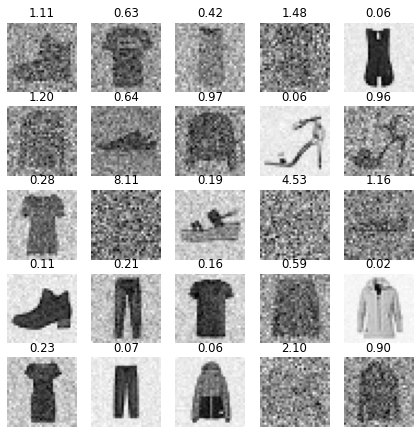

In [38]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

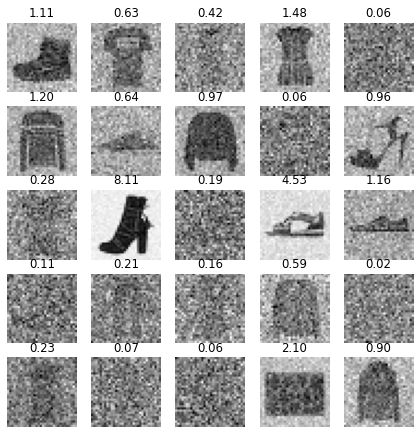

In [39]:
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

The `noised_input` has a standard deviation of 1, the means is not zero, but why would it be, we didn't do anything about the means,
The paper only cared about having the variance 1.
<br>
TODO: Adjust the input and output to have a mean of zero, as it does seem to help a bit...
(But it is less important than the variance.)
The `target` also has std of 1.

In [40]:
noised_input.mean(),noised_input.std(),target.mean(),target.std()

(tensor(-0.69267), tensor(1.01760), tensor(-0.39113), tensor(1.03463))

## Train

The UNets are the same, the initialization is the same, this is all the same.

In [41]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [42]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [43]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

Train it for a while.
We can't compare the losses because our target is different.

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


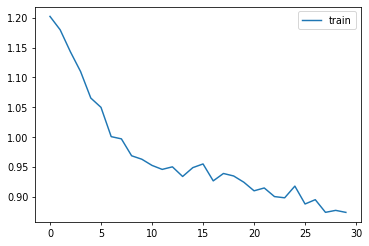


KeyboardInterrupt



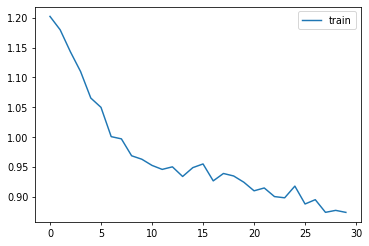

In [44]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model, 'models/fashion_karras.pkl')
# model = learn.model = torch.load('models/fashion_karras.pkl').cuda()

We define a `denoise()` that just takes the thing we had in `noiseify` and solve for X0,
they're going to multiply by `c_out` and then add `noised_input*c_skip`.
Above it is multiplied by `c_out` add noise 10.6.

In [ ]:
def denoise(target, noised_input): return target*c_out + noised_input*c_skip

We can do noise so let's grab our sigmas from the actual batch we had.
Let's calculate `c_skip, c_out, c_in` for the sigmas in our minibatch.
Let's use the model to predict the target given the noised input and the sigmas and then denoise it.

In [ ]:
with torch.no_grad():
    sigr = sig.cuda().reshape(-1,1,1,1)
    c_skip,c_out,c_in = scalings(sigr)
    targ_pred = learn.model((noised_input.cuda(),sig.cuda()))
    x0_pred = denoise(targ_pred, noised_input.cuda()/c_in)    

Here is our `noised_input` which we've already seen.

In [ ]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

And here are our remarkable predictions. 
One that we can barely see it found it, look at the shirt there's the shirt here, it is finding the little thing on the front. 
See below what it should look like.
In cases where the $\sigma$ is pretty high, it's saying maybe it's shoes but it could be something else.
It wasn't shoes but at least it's got the the bulk of the pixels.
For the 4.5 it has no idea what it is, maybe shoes maybe pants. 

In [ ]:
show_images(x0_pred[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [ ]:
show_images(denoise(target.cuda(), noised_input.cuda()/c_in)[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

Another exploration is with a $\sigma$ of 80 (considered the Pure Noise level), used when sampling from Pure Noise.
We created some Pure Noise and denoised it just for one step, and it overlaid all the possibilities.
We can see a pair of shoes, pair of pants, etc.
Sometimes it is more confident that the noise is actually a pair of pants, and sometimes that it's shoes.
We get a sense of how from Pure Noise it starts to make a call about what this noise has been covering up.
<br>
This first step from Pure-noise to something is a bit which JH feels least convinced about in diffusion models.
It is trying to have a good mix of all possible things.
It feels a bit handwavy, it works well, but not sure if it's getting the full range of possibilities.
Some papers say that maybe this is not the right approach.
Later we may look at some of the ones that look at VQ models and tokenized stuff.
Is interesting to see pictures (never seen any like this).

In [45]:
sig_r = tensor(80.).cuda().reshape(-1,1,1,1)
c_skip,c_out,c_in = scalings(sig_r)
x_r = torch.randn(32,1,32,32).to(model.device)*sig_r
with torch.no_grad():
    targ_pred = learn.model((x_r*c_in,sig_r.squeeze()))
    x0_pred = denoise(targ_pred, x_r)
show_images(x0_pred[:25], imsize=1.5)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_74403/2295772736.py:1 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_74403/2295772736.py'                 │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/cuda/__init__.py:221 in     │
│ _lazy_init                                                                                       │
│                                                                                                  │
│   218 │   │   │   │   "Cannot re-initialize CUDA in forked subprocess. To use CUDA with "        │
│   219 │   │   │   │   "multiprocessing, you must use the 'spawn' start method")                  │
│   220 │   │   if not hasattr(torch._C, '_cuda_getDeviceCount'):                                  │
│ ❱ 221 │   │   │   raise AssertionError("Torch not compiled with CUDA enabled")                   │
│   222 │   │   if _cudart is None:                                                                │
│   223 │   │   │   raise AssertionError(                                                          │
│   224 │   │   │   │   "libcudart functions unavailable. It looks like you have a broken build?   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: Torch not compiled with CUDA enabled

In [ ]:
x0_pred.max(),x0_pred.min(),x0_pred.mean(),x0_pred.std()

## Sampling

Sampling becomes simpler.
Code in the sampling section is inspired/copied from Cat's K diffusion repo, which has great generative modeling code.
Before we talk about sampling we need to talk about what $\sigma$ we use at each timestep.
Previously we've always done something sketchy, just linearly gone down the $\sigma$s (alphabars) or the $t$'s.
Sampling in the previous notebook used `linspace`, which was questionable.
At the start it was just noise, so we did not care. 
In DDPMV3 we experimented with something that intuitively made more sense:
For the first 100 timesteps we only run the model every 10 times, for the next 100 we run it 9 times,
the next 100 every 8 times, i.e., at the start be less careful.

In [46]:
from miniai.fid import ImageEval

In [47]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 1024 #2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_74403/3762458696.py:1 in <module>     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/d0/mqk8_wqx39j87cld43llgktm0000gn/T/ipykernel_74403/3762458696.py'                 │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:771 in     │
│ load                                                                                             │
│                                                                                                  │
│    768 │   if 'encoding' not in pickle_load_args.keys():                                         │
│    769 │   │   pickle_load_args['encoding'] = 'utf-8'                                            │
│    770 │                                                                                         │
│ ❱  771 │   with _open_file_like(f, 'rb') as opened_file:                                         │
│    772 │   │   if _is_zipfile(opened_file):                                                      │
│    773 │   │   │   # The zipfile reader is going to advance the current file position.           │
│    774 │   │   │   # If we want to actually tail call to torch.jit.load, we need to              │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:270 in     │
│ _open_file_like                                                                                  │
│                                                                                                  │
│    267                                                                                           │
│    268 def _open_file_like(name_or_buffer, mode):                                                │
│    269 │   if _is_path(name_or_buffer):                                                          │
│ ❱  270 │   │   return _open_file(name_or_buffer, mode)                                           │
│    271 │   else:                                                                                 │
│    272 │   │   if 'w' in mode:                                                                   │
│    273 │   │   │   return _open_buffer_writer(name_or_buffer)                                    │
│                                                                                                  │
│ /Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/serialization.py:251 in     │
│ __init__                                                                                         │
│                                                                                                  │
│    248                                                                                           │
│    249 class _open_file(_opener):                                                                │
│    250 │   def __init__(self, name, mode):                                                       │
│ ❱  251 │   │   super(_open_file, self).__init__(open(name, mode))                                │
│    252 │                                                                                         │
│    253 │   def __exit__(self, *args):                                                            │
│    254 │   │   self.file_like.close()                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 'mode

In [ ]:
sz = (bs,1,32,32)

The NVIDIA team's paper ran a whole bunch of experiments.

The `sigmas_karras()` function creates the schedule of reverse diffusion $\sigma$ steps.
It's a bit of weird function in that it's the $\rho$ (`rho`) root of $\sigma$, where `rho=7`,
i.e., the seventh root of sigma is basically what it's scaling on.
They choose that seventh root because they tried it and it worked well.

In [ ]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7., device='cpu'):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).to(device)

At the start of training we can start with a high $\sigma$, 
then step to a lower $\sigma$ in the next step, and then a much slower $\sigma$ ...
The longer we train we step by smaller steps, so we spend more time fine-tuning carefully at the end,
and not much time at the start.

This is the sigma we're going to jump to.

In [ ]:
sk = sigmas_karras(100)
plt.plot(sk);

The denoising `denoise(model, x, sig)` is going to involve calculating the `c_skip, c_out, c_in`,  and calling our model
with the `c_in` scaled data `x` and the sigma `sig`, and then scaling it with `c_out` and then doing the `c_skip`.
That is just undoing the noisify.

In [ ]:
def denoise(model, x, sig):
    c_skip,c_out,c_in = scalings(sig)
    return model((x*c_in, sig))*c_out + x*c_skip

`ancestral_euler_sampler()` does the denoising in the usual way, and also adds rand.
We need to ensure is given that we're adding a certain amount of randomness, we need to remove that amount of randomness
from the steps that we take.
Without going into the details, there is a way of calculating how much new randomness and how much
just going back in the existing direction we do.

There's the amount in the existing direction and there's the amount in the new random direction.
We can pass in `eta` to scale that, e.g., if we scale it by half, half of it is new noise,
and half of it is going in the direction that we thought we should go.
That makes it better still, again with 100 steps adding a bit of extra noise now.

In [ ]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to,var_from = sigma_to**2,sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to-sigma_up**2)**0.5, sigma_up

In [ ]:
@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

This is all that is required to do one step of denoising for the simplest sampler which is called Euler.
What's a sigma `sig` at time step `i` what's the `sig2` at time step `i`.
A timestep is the sampling step, e.g., from the `sigmas_karras()` function.
Then `denoise(model,x,sig)`, and then just send back whatever `x` you were given, plus move a little bit in the direction of the denoised image.
The direction is `x - denoised` (that is the gradient) (as discussed in Lesson 9?)
We take the noise, if we divide it by `sig` we get a slope, `(x - denoised)/sig`, how much noise is there per sigma.
And the amount that we are stepping is `sig2-sig`. 
Take that slope and multiply it by the change, that's the distance to travel towards the noise for this fraction.

Alternatively, by an obvious algebraic change, we could think of `(sig2-sig)/sig` as being 
of the total amount of noise the change in sigma we're doing what percentage is that.
That is the amount we should step.
These are two ways of thinking about the same thing.
We're going to need to do this once per sampling step.

In [ ]:
@torch.no_grad()
def sample_euler(x, sigs, i, model):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    return x + (x-denoised)/sig*(sig2-sig)

[Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method) does something which we can pictorially see 
[Heun's Diagram](https://en.wikipedia.org/wiki/File:Heun%27s_Method_Diagram.jpg) here, to decide where to go.
Where are we right now, what is the direction at the current Point.
We take the tangent line (the slope) and that takes us to a a new spot.
At that new spot we calculate a (new) slope,  and then we go halfway between the two.
Each of these slopes is inaccurate, so we calculate the slope of where we are,
the slope of where we're going, and then go halfway between the two.

Lets compare Heun to Euler.
We do the same first line, then the `denoised = denoise()` is the same.
Then the (Euler "return step") is written in multiple steps in `sample_heun`.
If this is the last step then we're done (so the last step is Euler).
For an Euler step this is where we'd go... what does that look like if we denoise?
So this calls the model a second time right.
Where would that take us if we took an Euler step there?
Here we are taking another step.
It is just like in the picture, let's take the average and then use that the step.
That is all the Heun sampler does.
This just takes the average of the slope where we're at and the slope where the Euler method would have taken us.
Notice that it called the model twice for a single step, so to be fair since we've been taking 100 steps with Euler, 
we should take 50 steps with Heun.
Now we beat it. 
We can even go down to 20, which is doing 40 model evaluations, and it is better than our best Euler.

In [ ]:
@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt

`sample()` does that.
At the very start we need to create our Pure Noise image:
`x = torch.randn(sz).to(model.device)*sigma_max`
The amount of noise we start with got a sigma of 80. 
Then we need to grab our list of sigmas `sigs` to start with
`sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)`
Then going through each sampling step, `range(len(sigs)-1)`,
call the `sampler()` which initially we're going to use `sample_euler`, with that information,
add it to our list of results `preds.append(x)`, and do it again.
That is all the sampling is.

In [ ]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    for i in progress_bar(range(len(sigs)-1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

We call `sample` using `sample_euler` and we get back good looking images and the FID is 1.98,
from a simple sampler (3 lines of code plus a loop), which is better than the cosine.
We can improve it.
Notice that we added no new noise, this is a deterministic scheduler, there's no rand anywhere.
We can do `ancestral_euler_sampler` which does the denoising in the usual way, and also adds rand.

In [ ]:
# preds = sample_lms(model, steps=20, order=3)
# preds = sample(sample_euler_ancestral, model, steps=100, eta=0.5)
preds = sample(sample_euler, model, steps=100)
# preds = sample(sample_heun, model, steps=20, s_churn=0.5)

In [ ]:
s = preds[-1]
s.min(),s.max()

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [ ]:
# euler 100
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# euler 100
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# ancestral 100 0.5
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# heun 50
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# heun 20
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# heun 20, churn 0.5
ie.fid(s),ie.kid(s),s.shape

In [ ]:
# lms 20
ie.fid(s),ie.kid(s),s.shape

We can compare with an actual minibatch of data `xb` we get about 0.5.
This is quite a great result, close to real data in FID, with 40 model evaluations.
And the key here is making sure we've got unit variance inputs, unit variance outputs, 
and equally difficult problems to solve in the loss function.


In [ ]:
# reals
ie.fid(xb)

In [ ]:
from scipy import integrate

In [ ]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

Something weird/silly is that we're calling the model twice just to average them.
But we already have 2 model results without calling it twice, because we can just look at the previous timestep.
The LMS sampler does that, if I call LMS with 20 it actually does 20 evaluations, and it beats Euler with 100 evaluations.
We won't go into the details of LMS, it didn't actually fit into my little sampling very well,
so JH copied and pasted Cat's code.
The key thing it does is it gets the current `sig` Sigma, it does the denoising `denoised = denoise(model,x,sig)`, 
it calculates the slope, `d = (x-denoised)/sig`, and it stores the slope in a list `ds.append(d)`.
It then grabs the first one from the list, `ds.pop(0)`, so it's kind of keeping a list of up to `order`, which is 4,  at a time.
It then uses up to the last four to basically (yes??) the curvature of this and take the next step.
That is pretty smart.
If we want to do super fast sampling, this seems like a pretty good way to do it.

In [ ]:
@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds

### Comments

People started to move towards a new similar sampler called the [DPM++](https://arxiv.org/abs/2211.01095) but it's the same idea, 
keep a list of recent results and use that.

J: Having a different schedule for sampling that is unrelated to the training schedule, in Karras paper,
could apply to existing diffusion models that have been trained by others. 
Using the Karras sampler in fewer steps we can get better results without any other changes.
They do rearrange equations to get the other papers versions into their `c_skip, c_in, c_out` framework.
Stable diffusion (V1?) was trained ddpm style training Epsilon objective.
Now we can get these different samplers and different sampling schedules and do it in 15-20 steps, and get pretty nice images. 

JH: Also, "elucidating the design space of diffusion-based models" adopted various different approaches,
and explained what they are all doing the same thing when we parameterize as seen in Table 1.
If we fill in these parameters we get paper A, these parameters is paper  B, etc.
Then we found a better set of parameters which ended up simplifying things.
Looking through this notebook the code is simple compared to all the previous ones.
Every notebook we've done from DDPM onwards the code's got easier to understand.